### Data Processing and PCA

In [8]:
from define_classes import *
from data_processing import *
from pca import *
from csv_clean import *
from polynomial_regression import *

### Mergind and classifying data for red and white wines

In [50]:
csv1 = 'white.csv'
csv2 = 'red.csv'
c = CleanCsv(csv1,csv2)
data = c.merge_csv(csv1,csv2)

Class 0 is white.csv values. Class 1 is red.csv values


### Setting the number of classes for different wine quality points threshold

In [51]:
data = pd.read_csv('data.csv', index_col=0)
print('Possible thresdholds for classification:',np.sort(data['quality'].unique()))

Possible thresdholds for classification: [3 4 5 6 7 8 9]


In [53]:
target = 'cat'
n_c = 4 # bad, average, good wine
thres = [4,6,7,8]
value = 'quality'

In [54]:
if n_c==2:
            data[target] = data[value].apply(lambda x: 0 if x<=thres[0] else 1).astype('int')
elif n_c==3:
            data[target] = data[value].apply(lambda x: 0 if x<=thres[0] else (1 if x <=thres[1] else 2)).astype('int')
elif n_c==4:
            data[target] = data[value].apply(lambda x: 0 if x<=thres[0] else (1 if x <=thres[1] else(2 if x <=thres[2]  else (3)))).astype('int')

# Re-write the data csv to update the classes or create a new csv with different classes
data.to_csv('data.csv')

In [55]:
data['cat'].value_counts()

1    4974
2    1079
0     246
3     198
Name: cat, dtype: int64

#### We can see a large inbalance in the very good(class 3) and bad wines (class 0)

In [86]:
from sklearn import datasets, metrics
from sklearn.utils.class_weight import compute_sample_weight
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import recall_score, classification_report, accuracy_score, precision_score
from ordinal import *
import numpy as np
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression


In [15]:
# Splitting Data

csv = 'data.csv'
d = DataClean(csv)
df_mm, num_scale = d.read_scale(csv)
X_train, X_test, y_train, y_test = d.index(csv)

### Balancing the Classes : SMOTE

In [16]:
smt = SMOTE(sampling_strategy='not majority', k_neighbors=3)
X_train_s, y_train_s = smt.fit_sample(np.asarray(X_train), np.asarray(y_train))

X_test_s, y_test_s = smt.fit_sample(np.asarray(X_test), np.asarray(y_test))
col = list(num_scale.columns)
# X_test_smote = pd.DataFrame(X_test_s, columns=col)
# y_test_smote = pd.DataFrame(y_test_s, columns=['cat'])

X_train_smote = pd.DataFrame(X_train_s, columns=col)
y_train_smote = pd.DataFrame(y_train_s, columns=['cat'])

smote_df = X_train_smote.join(y_train_smote)

smote_df.groupby('cat').count().iloc[:,0]

cat
0    3982
1    3982
2    3982
3    3982
Name: fixed acidity, dtype: int64

# Performance Comparison: All Features - 4 Classes

### Ordinal Classification 

Ordinal variables are those whose value exists on an arbitrary scale where only the relative ordering between different values is significant. In our case 0 to 3 is the order definining the incremental quality of wine. Therefore the estimation should take into account that our variables are 'order-dependent'.    
A way to tackle this type of classes (ordered) is using the 'OrdinalClassifier' class available for python in GitHub. This will create binary vectors for each class. This can be applied to classifiers that generate classes probability, or in python what we know as 'predict_proba'

In [17]:
clf = OrdinalClassifier(RandomForestClassifier(max_depth=9, class_weight='balanced'))

In [18]:
clf.fit(X_train_smote, y_train_smote)

/Users/flatironschool/Documents/Final Project/Final_project/ordinal.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X, binary_y)
/Users/flatironschool/Documents/Final Project/Final_project/ordinal.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X, binary_y)
/Users/flatironschool/Documents/Final Project/Final_project/ordinal.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X, binary_y)


In [19]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.13      0.71      0.22        55
           1       0.91      0.56      0.70       992
           2       0.51      0.39      0.44       211
           3       0.14      0.76      0.24        42

    accuracy                           0.55      1300
   macro avg       0.42      0.61      0.40      1300
weighted avg       0.79      0.55      0.62      1300



### Logistic Regression for multiclass

In [20]:
logit = LogisticRegression(C =1e9 ,solver='newton-cg',fit_intercept=True, multi_class='multinomial',)

model = logit.fit(X_train_smote,y_train_smote)
model.intercept_, model.coef_
y_log = model.predict(X_test)
print(classification_report(y_test, y_log))
print(round(logit.score(X_test,y_test), 4))

/Users/flatironschool/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

           0       0.13      0.69      0.21        55
           1       0.88      0.41      0.56       992
           2       0.28      0.34      0.31       211
           3       0.10      0.67      0.17        42

    accuracy                           0.42      1300
   macro avg       0.35      0.53      0.31      1300
weighted avg       0.73      0.42      0.49      1300

0.4162


#### Very little predictive power for three out of four classes

### Baseline Model: Decission Tree

In [21]:
dt = DecisionTreeClassifier(criterion='entropy', class_weight='balanced')
dt_model = dt.fit(X_train_smote, y_train_smote)
y_test_hat = dt_model.predict(X_test)

print(classification_report(y_test, y_test_hat))
# precision and recall are very similar
print(round(accuracy_score(y_test, y_test_hat), 3))

              precision    recall  f1-score   support

           0       0.21      0.29      0.24        55
           1       0.88      0.79      0.83       992
           2       0.49      0.59      0.53       211
           3       0.27      0.48      0.35        42

    accuracy                           0.73      1300
   macro avg       0.46      0.54      0.49      1300
weighted avg       0.77      0.73      0.74      1300

0.727


<BarContainer object of 5 artists>

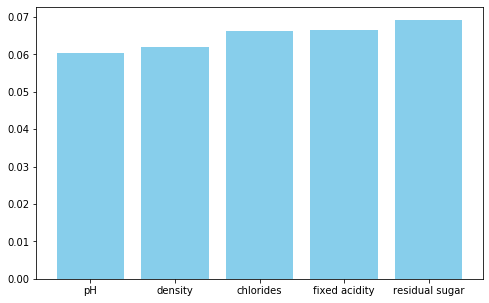

In [22]:
dt_feature_importance = [(X_train.columns[i[0]], i[1]) for i in list(enumerate(dt_model.feature_importances_))]
dt_feature_importance = sorted(dt_feature_importance, key = lambda x: x[1], reverse = False)[:5]
fig = plt.figure(figsize = (8,5))
plt.bar([i[0] for i in dt_feature_importance], [i[1] for i in dt_feature_importance], color='skyblue')

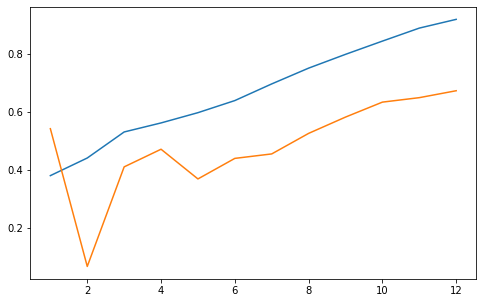

In [23]:
train_accuracy_scores = []
test_accuracy_scores = []
depths = list(range(1,13))
for i in depths:
    dt_n = DecisionTreeClassifier(max_depth = i)
    model_n = dt_n.fit(X_train_smote, y_train_smote)
    y_train_hat = model_n.predict(X_train_smote)
    y_test_hat = model_n.predict(X_test)
    train_accuracy_scores.append(accuracy_score(y_train_smote, y_train_hat))
    test_accuracy_scores.append(accuracy_score(y_test, y_test_hat))
fig = plt.figure(figsize = (8,5))
plt.plot(depths, train_accuracy_scores);
plt.plot(depths, test_accuracy_scores);
# 7 to 10 is an appropriate range for tree depth

#### GridSearch CV

In [24]:
dt_params = {'criterion': ['gini', 'entropy'], 'max_depth': list(range(3,12))}
dt_gs = GridSearchCV(dt, dt_params, cv = 8, scoring = 'roc_auc_ovr' )
dt_model_gs = dt_gs.fit(X_train_smote, y_train_smote)
y_test_hat = dt_model_gs.predict(X_test)

In [25]:
dt_model_gs.best_params_

{'criterion': 'entropy', 'max_depth': 11}

In [26]:
dt = DecisionTreeClassifier(criterion='entropy', max_depth=11, class_weight='balanced')
dt_model_cv = dt.fit(X_train_smote, y_train_smote)
y_test_hat = dt_model.predict(X_test)

print(classification_report(y_test, y_test_hat))
# precision and recall are very similar
print(round(accuracy_score(y_test, y_test_hat), 3))

              precision    recall  f1-score   support

           0       0.21      0.29      0.24        55
           1       0.88      0.79      0.83       992
           2       0.49      0.59      0.53       211
           3       0.27      0.48      0.35        42

    accuracy                           0.73      1300
   macro avg       0.46      0.54      0.49      1300
weighted avg       0.77      0.73      0.74      1300

0.727


<BarContainer object of 5 artists>

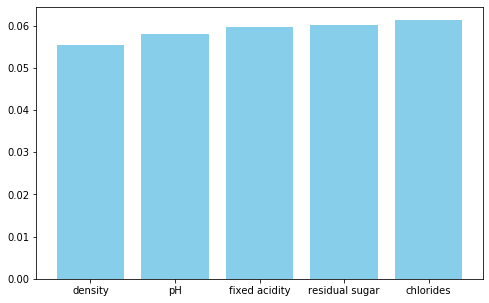

In [27]:
dt_feature_importance = [(X_train.columns[i[0]], i[1]) for i in list(enumerate(dt_model_cv.feature_importances_))]
dt_feature_importance = sorted(dt_feature_importance, key = lambda x: x[1], reverse = False)[:5]
fig = plt.figure(figsize = (8,5))
plt.bar([i[0] for i in dt_feature_importance], [i[1] for i in dt_feature_importance], color='skyblue')

### SVM using calss_weight instead of SMOTE balancing

In [28]:
# Create support vector classifier

svc = SVC(kernel="linear", class_weight="balanced", C=1.0, random_state=0) # Train classifier
sv_model = svc.fit(X_train, y_train)

y_sv = sv_model.predict(X_test)
print(classification_report(y_test, y_sv))
print(round(accuracy_score(y_test, y_sv), 3))

              precision    recall  f1-score   support

           0       0.13      0.65      0.22        55
           1       0.89      0.45      0.60       992
           2       0.29      0.36      0.32       211
           3       0.11      0.67      0.18        42

    accuracy                           0.45      1300
   macro avg       0.36      0.53      0.33      1300
weighted avg       0.74      0.45      0.52      1300

0.45


### SVM with SMOTE balancing

In [29]:
# Create support vector classifier

svc = SVC(kernel="linear", class_weight="balanced", C=1.0, random_state=0) # Train classifier
sv_model = svc.fit(X_train_smote, y_train_smote)

y_sv = sv_model.predict(X_test)
print(classification_report(y_test, y_sv))
print(round(accuracy_score(y_test, y_sv), 3))

/Users/flatironschool/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

           0       0.13      0.71      0.22        55
           1       0.89      0.43      0.58       992
           2       0.30      0.35      0.32       211
           3       0.10      0.67      0.18        42

    accuracy                           0.44      1300
   macro avg       0.35      0.54      0.32      1300
weighted avg       0.73      0.44      0.51      1300

0.435


In [30]:
print(svc.get_params())

{'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': 'balanced', 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'linear', 'max_iter': -1, 'probability': False, 'random_state': 0, 'shrinking': True, 'tol': 0.001, 'verbose': False}


### Random Forest

##### Finding Best Parameters

In [31]:
RF = RandomForestClassifier(n_estimators=1000, max_depth=12, random_state=0).fit(X_train_smote, y_train_smote)
y_rf = RF.predict(X_test)

/Users/flatironschool/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


In [32]:
print(round(RF.score(X_test, y_test), 4))
print(classification_report(y_test, y_sv))

0.7654
              precision    recall  f1-score   support

           0       0.13      0.71      0.22        55
           1       0.89      0.43      0.58       992
           2       0.30      0.35      0.32       211
           3       0.10      0.67      0.18        42

    accuracy                           0.44      1300
   macro avg       0.35      0.54      0.32      1300
weighted avg       0.73      0.44      0.51      1300



<BarContainer object of 5 artists>

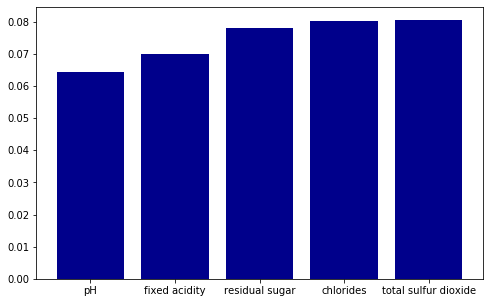

In [33]:
dt_feature_importance = [(X_train.columns[i[0]], i[1]) for i in list(enumerate(RF.feature_importances_))]
dt_feature_importance = sorted(dt_feature_importance, key = lambda x: x[1], reverse = False)[:5]
fig = plt.figure(figsize = (8,5))
plt.bar([i[0] for i in dt_feature_importance], [i[1] for i in dt_feature_importance], color='darkblue')

In [34]:
# rf_params = {'criterion': ['gini', 'entropy'], 'max_depth': list(range(9,12)), 'min_samples_split': [2]}
# rf_gs = GridSearchCV(RandomForestClassifier(n_estimators = 50), rf_params, cv = 5, scoring = 'accuracy')
# rf_model_gs = rf_gs.fit(X_train_smote, y_train_smote)
# y_test_hat = rf_model_gs.predict(X_test)

# Model Performance: PCA - 4 classes

Original number of features: 11
Reduced number of features: 10


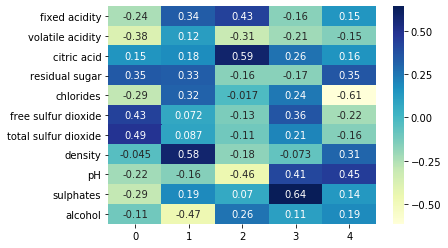

In [56]:
# Running PCA Analysis
csv = 'data.csv'
target = 'cat'
p = PcaAnalysis(csv,target)
pca, features_df = p.pca_features(csv,target)
g = p.get_components(csv,target,5)

# join pca components to dataframe and save on csv

pca_df = features_df.join(data['cat'])
# data.to_csv('pca.csv')

In [72]:
pca_df = features_df.join(data['cat'])
pca_df.to_csv('pca.csv')

In [71]:
data.reset_index(drop=True,inplace=True)

In [73]:
# Splitting Data
csv = 'pca.csv'
d = DataClean(csv)
df_mm, num_scale = d.read_scale(csv)
X_train, X_test, y_train, y_test = d.index(csv)

### Decision Tree for PCA components

From all the trained models above decision tree is the one that performed best for the 0 and 3 classes (bad and very good wines). We test the same model to see if there is any improvement with PCA

In [74]:
dt = DecisionTreeClassifier(criterion='entropy', class_weight='balanced')
dt_model = dt.fit(X_train, y_train)
y_test_hat = dt_model.predict(X_test)

print(classification_report(y_test, y_test_hat))
# precision and recall are very similar
print(round(accuracy_score(y_test, y_test_hat), 3))

              precision    recall  f1-score   support

           0       0.26      0.20      0.23        55
           1       0.87      0.86      0.87       992
           2       0.56      0.57      0.56       211
           3       0.31      0.43      0.36        42

    accuracy                           0.77      1300
   macro avg       0.50      0.52      0.50      1300
weighted avg       0.78      0.77      0.77      1300

0.773


Let's check future importance and remove the two least important features

<BarContainer object of 5 artists>

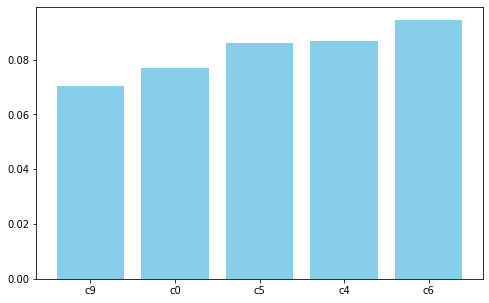

In [75]:
dt_feature_importance = [(X_train.columns[i[0]], i[1]) for i in list(enumerate(dt.feature_importances_))]
dt_feature_importance = sorted(dt_feature_importance, key = lambda x: x[1], reverse = False)[:5]
fig = plt.figure(figsize = (8,5))
plt.bar([i[0] for i in dt_feature_importance], [i[1] for i in dt_feature_importance], color='skyblue')

Now we remove from our dataframe component 9 and zero and test the model again

In [76]:
X_train_p = X_train.drop(columns=['c9','c0'],axis=1)
X_test_p  = X_test.drop(columns=['c9','c0'],axis=1)

y_train_p = y_train.drop(columns=['c9','c0'],axis=1)
y_test_p = y_test.drop(columns=['c9','c0'],axis=1)

In [77]:
dt = DecisionTreeClassifier(criterion='entropy', class_weight='balanced')
dt_model = dt.fit(X_train_p, y_train_p)
y_pred = dt_model.predict(X_test_p)

print(classification_report(y_test_p, y_pred))
# precision and recall are very similar
print(round(accuracy_score(y_test_p, y_pred), 3))

              precision    recall  f1-score   support

           0       0.18      0.18      0.18        55
           1       0.87      0.85      0.86       992
           2       0.53      0.56      0.55       211
           3       0.38      0.45      0.41        42

    accuracy                           0.76      1300
   macro avg       0.49      0.51      0.50      1300
weighted avg       0.77      0.76      0.76      1300

0.76


Class 3 (very good) has improved but we ha

### SVC PCA components

In [78]:
svc = SVC(kernel="linear", class_weight="balanced", C=1.0, random_state=0) # Train classifier
sv_model = svc.fit(X_train_p, y_train_p)

y_sv = sv_model.predict(X_test_p)
print(classification_report(y_test_p, y_sv))
print(round(accuracy_score(y_test_p, y_sv), 3))

              precision    recall  f1-score   support

           0       0.12      0.65      0.20        55
           1       0.88      0.42      0.57       992
           2       0.29      0.38      0.33       211
           3       0.10      0.64      0.18        42

    accuracy                           0.43      1300
   macro avg       0.35      0.52      0.32      1300
weighted avg       0.73      0.43      0.50      1300

0.429


### KNN

Finding best k

In [100]:
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.preprocessing import StandardScaler 
from sklearn.pipeline import Pipeline, FeatureUnion 
from sklearn.model_selection import GridSearchCV

knn = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
# Create a pipeline
pipe = Pipeline([("knn", knn)]) # Create space of candidate values
search_space = [{"knn__n_neighbors": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}, "knn__n_jons:"[-1,]]
# Create grid search
classifier = GridSearchCV(pipe, search_space, cv=5, verbose=0).fit(X_train_smote, y_train_smote.values.ravel())

In [101]:
classifier.best_estimator_.get_params()["knn__n_neighbors"]

1

In [106]:
from sklearn.neighbors import KNeighborsClassifier

precision = []
accuracy = []


for i in range(1,4):
    knn = KNeighborsClassifier(n_neighbors=1, metric='minkowski', p=i,)
    model = knn.fit(X_train, y_train.values.ravel())
    y_pred = knn.predict(X_test)
    precision.append(precision_score(y_test, y_pred, average='macro'))
    accuracy.append(accuracy_score(y_test, y_pred))
    
    
print('Highest precision:', max(precision))
print('Highest accuracy:',max(accuracy))

Highest precision: 0.5481770701785289
Highest accuracy: 0.803076923076923


In [113]:
knn = KNeighborsClassifier(n_neighbors=1, metric='minkowski', p=1)
model = knn.fit(X_train, y_train.values.ravel())
y_hat = knn.predict(X_test)

In [117]:
print(classification_report(y_test, y_hat))
print('Precision:', round(metrics.precision_score(y_test, y_hat, average='micro'),3))

              precision    recall  f1-score   support

           0       0.26      0.16      0.20        55
           1       0.88      0.89      0.88       992
           2       0.62      0.62      0.62       211
           3       0.43      0.48      0.45        42

    accuracy                           0.80      1300
   macro avg       0.55      0.54      0.54      1300
weighted avg       0.79      0.80      0.80      1300

Precision: 0.803


Text(0.5, 257.44, 'Predicted label')

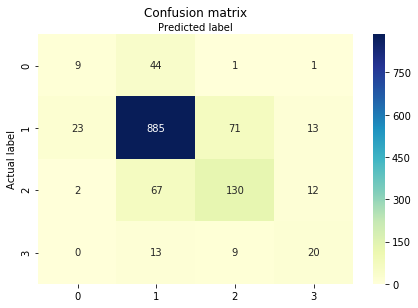

In [120]:
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_hat)
cnf_matrix

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap='YlGnBu' ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')